In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [2]:
dspath = []
for dirname, _, filenames in os.walk('./dataset/AndMal2020'):
    for filename in filenames:
        if filename.endswith('.csv'):
            dfp = os.path.join(dirname, filename)
            dspath.append(dfp)

In [3]:
# Lấy danh sách các cột từ file CSV đầu tiên
list(pd.read_csv(dspath[0], nrows=1))


['Memory_PssTotal',
 'Memory_PssClean',
 'Memory_SharedDirty',
 'Memory_PrivateDirty',
 'Memory_SharedClean',
 'Memory_PrivateClean',
 'Memory_SwapPssDirty',
 'Memory_HeapSize',
 'Memory_HeapAlloc',
 'Memory_HeapFree',
 'Memory_Views',
 'Memory_ViewRootImpl',
 'Memory_AppContexts',
 'Memory_Activities',
 'Memory_Assets',
 'Memory_AssetManagers',
 'Memory_LocalBinders',
 'Memory_ProxyBinders',
 'Memory_ParcelMemory',
 'Memory_ParcelCount',
 'Memory_DeathRecipients',
 'Memory_OpenSSLSockets',
 'Memory_WebViews',
 'API_Process_android.os.Process_start',
 'API_Process_android.app.ActivityManager_killBackgroundProcesses',
 'API_Process_android.os.Process_killProcess',
 'API_Command_java.lang.Runtime_exec',
 'API_Command_java.lang.ProcessBuilder_start',
 'API_JavaNativeInterface_java.lang.Runtime_loadLibrary',
 'API_JavaNativeInterface_java.lang.Runtime_load',
 'API_WebView_android.webkit.WebView_loadUrl',
 'API_WebView_android.webkit.WebView_loadData',
 'API_WebView_android.webkit.WebView_l

In [4]:
# Các cột không mong muốn
unwanted_columns = ['Hash', 'Family']

In [5]:
# Hàm để tải dữ liệu từ file CSV
def load_file(path):
    data = pd.read_csv(path)
    data.drop(columns=unwanted_columns, inplace=True)
    return data

In [6]:
# Kết hợp tất cả các file CSV thành một DataFrame duy nhất
df = pd.concat([load_file(dfp) for dfp in dspath], ignore_index=True)


In [7]:
# Đếm số lượng các loại tấn công khác nhau trong DataFrame 'df'
df['Category'].value_counts()


Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [8]:
df.shape

(53439, 142)

In [9]:
df.head()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_debug,Logcat_info,Logcat_warning,Logcat_error,Logcat_verbose,Logcat_total,Process_total,Category
0,46430,5156,11304,34336,86444,5176,0,15429,11470,3958,...,3,0,2961,3237,1742,959,124,9023,193,Adware
1,35437,3064,12396,25632,91220,3080,0,13074,10631,2442,...,2,0,2190,546,111,1077,1149,5073,191,Adware
2,56846,2340,10768,47296,95940,2592,0,16154,11361,4792,...,7,1,2226,5479,1712,610,145,10172,191,Adware
3,30576,1152,12664,24312,78192,1164,0,7913,4720,3192,...,2,0,1413,2517,9354,3688,117,17089,193,Adware
4,148452,19332,10808,122364,87080,20104,0,44830,34063,10766,...,2,0,110,1588,1310,3309,1530,7847,195,Adware


In [10]:
df.rename(columns={'Category': 'Label'}, inplace=True)
df.head()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_debug,Logcat_info,Logcat_warning,Logcat_error,Logcat_verbose,Logcat_total,Process_total,Label
0,46430,5156,11304,34336,86444,5176,0,15429,11470,3958,...,3,0,2961,3237,1742,959,124,9023,193,Adware
1,35437,3064,12396,25632,91220,3080,0,13074,10631,2442,...,2,0,2190,546,111,1077,1149,5073,191,Adware
2,56846,2340,10768,47296,95940,2592,0,16154,11361,4792,...,7,1,2226,5479,1712,610,145,10172,191,Adware
3,30576,1152,12664,24312,78192,1164,0,7913,4720,3192,...,2,0,1413,2517,9354,3688,117,17089,193,Adware
4,148452,19332,10808,122364,87080,20104,0,44830,34063,10766,...,2,0,110,1588,1310,3309,1530,7847,195,Adware


In [11]:
# Gộp các nhãn lại với nhau
def map_labels(label):
    if label == 'Riskware':
        return 'Riskware'
    elif label == 'Adware':
        return 'Adware'
    elif label == 'Ransomware':
        return 'Ransomware'
    elif label in ['Trojan', 'Trojan_Spy', 'Trojan_SMS', 'Trojan_Dropper', 'Trojan_Banker']:
        return 'Trojan'
    else:
        return 'Other'

df['Label'] = df['Label'].apply(map_labels)
df['Label'].value_counts()

Label
Trojan        15027
Riskware      14053
Adware        10980
Other          9968
Ransomware     3411
Name: count, dtype: int64

In [12]:
df['Label'].unique()

array(['Adware', 'Other', 'Ransomware', 'Riskware', 'Trojan'],
      dtype=object)

In [13]:
df.head()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_debug,Logcat_info,Logcat_warning,Logcat_error,Logcat_verbose,Logcat_total,Process_total,Label
0,46430,5156,11304,34336,86444,5176,0,15429,11470,3958,...,3,0,2961,3237,1742,959,124,9023,193,Adware
1,35437,3064,12396,25632,91220,3080,0,13074,10631,2442,...,2,0,2190,546,111,1077,1149,5073,191,Adware
2,56846,2340,10768,47296,95940,2592,0,16154,11361,4792,...,7,1,2226,5479,1712,610,145,10172,191,Adware
3,30576,1152,12664,24312,78192,1164,0,7913,4720,3192,...,2,0,1413,2517,9354,3688,117,17089,193,Adware
4,148452,19332,10808,122364,87080,20104,0,44830,34063,10766,...,2,0,110,1588,1310,3309,1530,7847,195,Adware


In [14]:
df.dtypes.value_counts()

int64     141
object      1
Name: count, dtype: int64

In [15]:
#xóa khoảng trắng ở đầu và cuối tên cột
df.columns = [col.strip() for col in df.columns]

In [16]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)


In [17]:
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        col_mean = df[column][np.isfinite(df[column])].mean()
        df[column].replace([np.nan, np.inf, -np.inf], col_mean, inplace=True)

C:\Users\kiryu\AppData\Local\Temp\ipykernel_102604\1421170426.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].replace([np.nan, np.inf, -np.inf], col_mean, inplace=True)


In [18]:
# Mã hóa cột 'Label' thành số
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

In [19]:
# Lấy ánh xạ giữa các nhãn gốc và các giá trị đã mã hóa
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
for label, encoded_value in label_mapping.items():
    print(f"Label: {label} - Encoded Value: {encoded_value}")

Label: Adware - Encoded Value: 0
Label: Other - Encoded Value: 1
Label: Ransomware - Encoded Value: 2
Label: Riskware - Encoded Value: 3
Label: Trojan - Encoded Value: 4


In [20]:
# Tách dữ liệu đầu vào (features) và nhãn (labels)
X = df.drop('Label', axis=1).values
y = df['Label'].values

In [21]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Chuyển đổi nhãn thành dạng one-hot
num_classes = len(label_encoder.classes_)
y_one_hot = to_categorical(y, num_classes=num_classes)

In [24]:
# Reshape dữ liệu thành dạng (samples, time_steps, features)
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape(-1, input_shape[0], 1)
X_test = X_test.reshape(-1, input_shape[0], 1)

In [25]:
# Hàm để tạo khối Inception
def inception_module(x, filters):
    branch1 = Conv1D(filters, 1, padding='same', activation='relu')(x)
    
    branch2 = Conv1D(filters, 1, padding='same', activation='relu')(x)
    branch2 = Conv1D(filters, 3, padding='same', activation='relu')(branch2)
    
    branch3 = Conv1D(filters, 1, padding='same', activation='relu')(x)
    branch3 = Conv1D(filters, 5, padding='same', activation='relu')(branch3)
    
    branch4 = MaxPooling1D(3, strides=1, padding='same')(x)
    branch4 = Conv1D(filters, 1, padding='same', activation='relu')(branch4)
    
    output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

In [26]:
# Xây dựng mô hình Inception CNN
input_layer = Input(shape=input_shape)
x = inception_module(input_layer, 64)
x = MaxPooling1D(pool_size=2)(x)

x = inception_module(x, 128)
x = MaxPooling1D(pool_size=2)(x)

x = inception_module(x, 256)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

cnn_model = Model(inputs=input_layer, outputs=output_layer)

In [27]:
# Tạo optimizer AdamW
optimizer = Adam(learning_rate=0.001)

In [28]:
# Biên dịch mô hình
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [29]:
# Khởi tạo EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Theo dõi giá trị mất mát trên tập kiểm tra
    patience=5,             # Số epoch không cải thiện trước khi dừng
    restore_best_weights=True # Khôi phục trọng số của mô hình với hiệu suất tốt nhất
)

In [30]:
# Huấn luyện mô hình
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=128
)

Epoch 1/10


268/268 [==============================] - 45s 150ms/step - loss: 0.9778 - accuracy: 0.6157 - val_loss: 0.7192 - val_accuracy: 0.7231
Epoch 2/10
268/268 [==============================] - 39s 145ms/step - loss: 0.7175 - accuracy: 0.7238 - val_loss: 0.6406 - val_accuracy: 0.7522
Epoch 3/10
268/268 [==============================] - 39s 147ms/step - loss: 0.6410 - accuracy: 0.7543 - val_loss: 0.5807 - val_accuracy: 0.7805
Epoch 4/10
268/268 [==============================] - 39s 146ms/step - loss: 0.5815 - accuracy: 0.7763 - val_loss: 0.5531 - val_accuracy: 0.7980
Epoch 5/10
268/268 [==============================] - 40s 147ms/step - loss: 0.5433 - accuracy: 0.7884 - val_loss: 0.5406 - val_accuracy: 0.8013
Epoch 6/10
268/268 [==============================] - 40s 148ms/step - loss: 0.5122 - accuracy: 0.8042 - val_loss: 0.5155 - val_accuracy: 0.8108
Epoch 7/10
268/268 [==============================] - 40s 150ms/step - loss: 0.4801 - accuracy: 0.8149 - val_loss: 0.5135 - val_

In [31]:
# Đánh giá mô hình
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

334/334 [==============================] - 4s 13ms/step - loss: 0.4848 - accuracy: 0.8229
Loss: 0.48481664061546326
Accuracy: 0.8228854537010193


In [32]:
cnn_model.save('cnn_model.h5')

C:\Users\kiryu\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


334/334 [==============================] - 4s 12ms/step


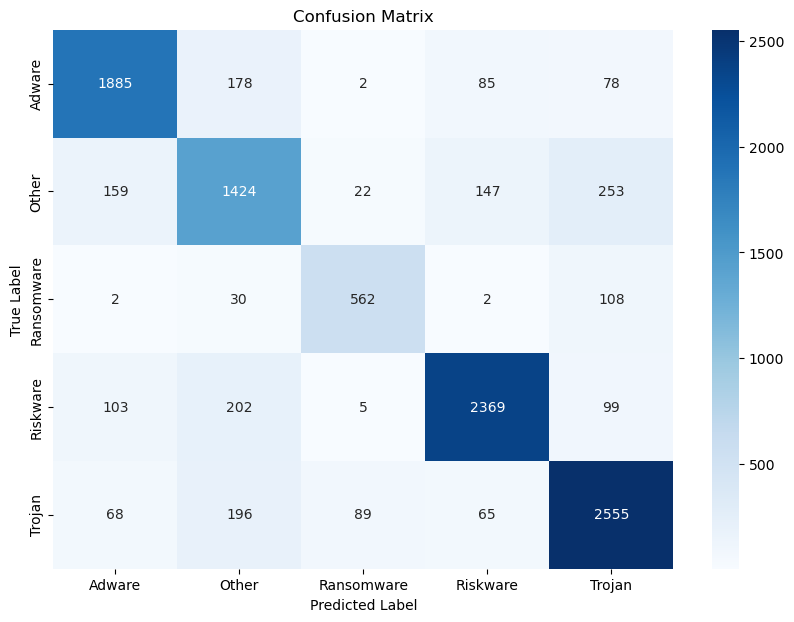

In [33]:
# Dự đoán lớp
y_pred_proba = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(label_encoder.classes_)))

# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Tính toán Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Tính toán Precision
precision = precision_score(y_true, y_pred, average='weighted')  # Có thể thay đổi 'weighted' thành 'macro' hoặc 'micro'

# Tính toán Recall
recall = recall_score(y_true, y_pred, average='weighted')  # Có thể thay đổi 'weighted' thành 'macro' hoặc 'micro'

# Tính toán F1-score
f1 = f1_score(y_true, y_pred, average='weighted')  # Có thể thay đổi 'weighted' thành 'macro' hoặc 'micro'

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8229
Precision: 0.8238
Recall: 0.8229
F1 Score: 0.8232


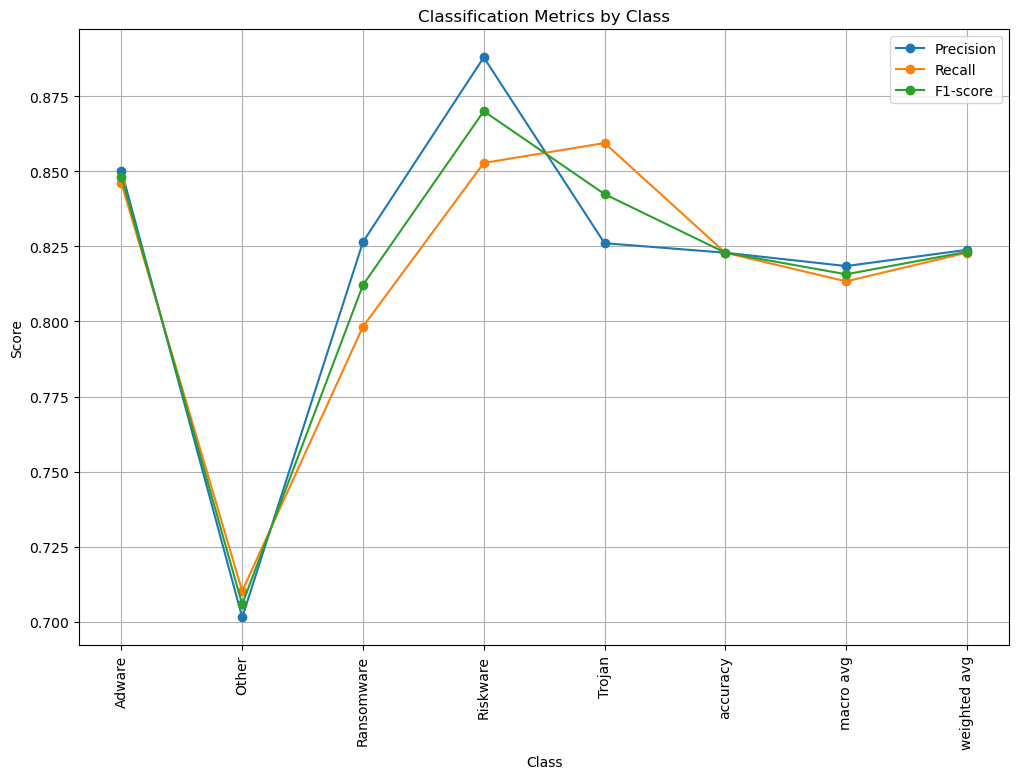

In [74]:
# Tính toán báo cáo phân loại
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
# Chuyển đổi báo cáo phân loại thành DataFrame
report_df = pd.DataFrame(report).transpose()

# Chọn các chỉ số cần vẽ
metrics = ['precision', 'recall', 'f1-score']

# Tạo hình ảnh
plt.figure(figsize=(12, 8))

for metric in metrics:
    plt.plot(report_df.index, report_df[metric], marker='o', label=f'{metric.capitalize()}')

plt.xticks(rotation=90)
plt.title('Classification Metrics by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()